In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
from get_train_test_1 import split_train_test
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import cv2

# Creation of the data

## Creation of files train-val and test - Sentinel (data_HR)

In [5]:

# change the data path here
data_HR_path= Path('data_HR') 
images_path=str(data_HR_path/'data'/'images')

#Names to the files
train_val_file='train_val_2'
test_file='test_2'
percent_test=0.10 #10%

In [169]:
split_train_test(original_dataset_dir= images_path, 
                 base_dir = str(data_HR_path),
                 test_split = percent_test, 
                 train_file=train_val_file,
                 test_file=test_file)

7670 6903 767
data_HR/train_val_2/images
data_HR/test_2/images


## Creation of files train-val and test - Sentinel (data_HR)

In [170]:
# change the data path here
data_HR_path= Path('data_VHR') 
images_path=str(data_HR_path/'data'/'images')

#Names to the files
train_val_file='train_val_850_2'
test_file='test_850_2'
percent_test=0.10 #10%

split_train_test(original_dataset_dir= images_path, 
                 base_dir = str(data_HR_path),
                 test_split = percent_test, 
                 train_file=train_val_file,
                 test_file=test_file)

# Plot  images + mask

In [181]:
def mask_overlay(image, mask, color=(15, 15, 0)):
    """
    Helper function to visualize mask over the img
    """
    print(mask.shape)      
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.float32)
    weighted_sum = cv2.addWeighted(mask, 0.3, image, 0.7, 0.)
    img = image.copy()
    ind = mask[:, :, 0] > 0  
    img[ind] = weighted_sum[ind]

    return img

def plot_img_mask(img_path,source='satellite'):
    img = np.load(str(img_path))
    if source=='satellite':
        img=img.transpose(1,2,0)
    print(np.shape(img),np.min(img),np.max(img))

    img2 = (img[:,:,:3].astype(np.float32))/np.max(img)
    #inp = (img*255).astype(np.uint8)
    mask = np.load(str(img_path).replace('images', 'masks').replace(r'.npy', r'_a.npy'), 0)
    mask=mask.transpose(1, 2, 0).reshape(mask.shape[1],-1)
    mask=(mask > 0).astype(np.float32)

    fig = plt.figure(figsize=(30, 30))  
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    ax1=plt.subplot(131)
    ax1.imshow(img2)
    ax2=plt.subplot(132)
    ax2.imshow(mask)

    ax3=plt.subplot(133)
    ax3.imshow(mask_overlay(img2, mask))


## PeruSat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 4) 84 1245
(512, 512)


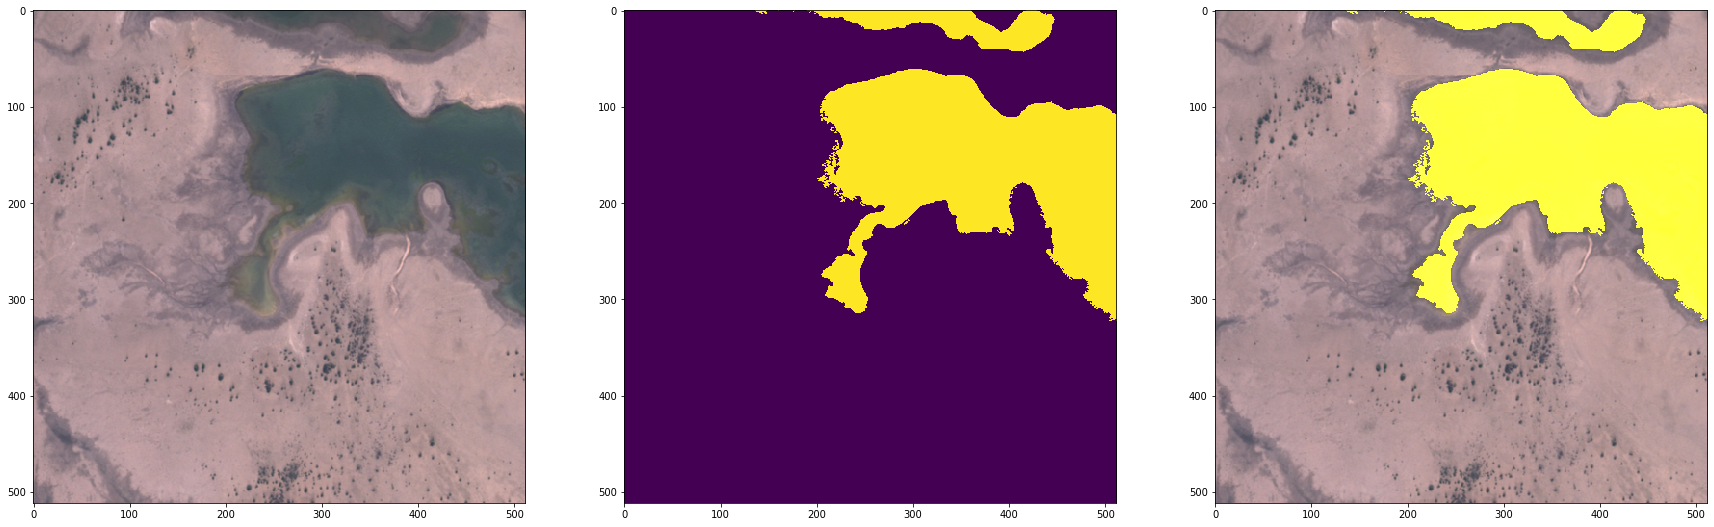

In [173]:
img_path ="data_VHR/train_val_850/images/rgbnir23072-3072.npy"
plot_img_mask(img_path)


## Sentinel

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 4) 0.04019999876618385 0.3898000121116638
(64, 64)


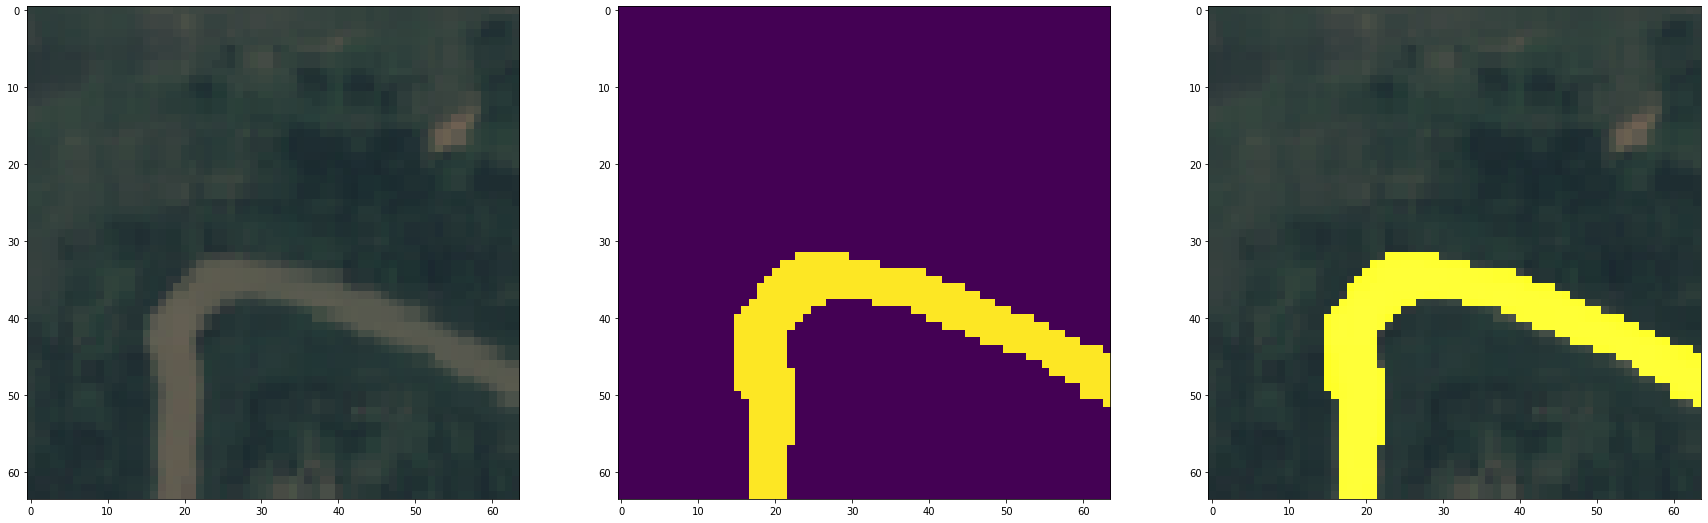

In [159]:
img_path ="data_HR/test_HR/images/rgbnir7585.npy"
plot_img_mask(img_path)

## Find some parameters of the data: max,std

In [235]:
import glob  ###
import os
from get_train_test_kfold import get_split_out, percent_split, get_split_in
from scalarmeanstd import meanstd

data_path= Path('data_VHR') 
train_val_file='train_val_850'
test_file='test_850'
input_channels=4
train_val_file_names=np.array(sorted(glob.glob(str(data_path/train_val_file/'images')+ "/*.npy")))
test_file_names =  np.array(sorted(glob.glob(str(data_path/test_file/'images') + "/*.npy")))
    
train_file_names,val_file_names = get_split_in(train_val_file_names,0)
max_values, mean_values, std_values=meanstd(train_file_names, val_file_names,test_file_names,str(data_path),input_channels) #_60 
print(max_values, mean_values, std_values)


elapsed time: 4.781440141610801
Train: data_VHR 680 min  0 max  3521
mean:[0.11555246 0.10432396 0.1150794  0.14246734]
std:[0.08946183 0.06699049 0.05742599 0.11001556]
Val: data_VHR 171 min  0 max  3413
mean:[0.11037574 0.10181481 0.11340307 0.13146787]
std:[0.09269447 0.07017382 0.06007207 0.11270477]
Test: data_VHR 94 -min  0 max  3270
mean:[0.10769105 0.09666061 0.10785635 0.13395942]
std:[0.08557147 0.06195216 0.05175427 0.11169893]
All: data_VHR 945 min  0 max  3521
mean:[0.11383374 0.10310764 0.11405758 0.13963067]
std:[0.08972336 0.06713878 0.05742005 0.11076992]
3521 [0.11555246 0.10432396 0.1150794  0.14246734] [0.08946183 0.06699049 0.05742599 0.11001556]


## Predictions unlabel images

In [6]:
##
from unlabeled_plotting import plot_prediction
path_model_VHR='logs_VHR/mapping/model_40epoch_100_percent_UNet11_fold0.pth'
file_unlabel='images_jungle'
plot_prediction(path_model=path_model_VHR,unlabel_name_file=file_unlabel)

RuntimeError: CUDA error: out of memory

## Test img of LR with the model HR  

In [ ]:
##
from unlabeled_plotting import plot_prediction
path_model_VHR='logs_VHR/mapping/model_40epoch_100_percent_UNet11_fold0.pth'
file_unlabel='images_sentinel'
plot_prediction(path_model=path_model_VHR,unlabel_name_file=file_unlabel)

In [ ]:
# prediction mask in HR images downscale 

#import math
import helper
#from pathlib import Path
from collections import defaultdict
from helper import reverse_transform2
from torch.utils.data import DataLoader
from loss import dice_loss,metric_jaccard  #this is loss
from dataset import WaterDataset
import torch.nn.functional as F
from models import UNet11
import numpy as np
import torch
import glob
import os
import torch.nn as nn
import matplotlib.pyplot as plt

from transformsdata import (DualCompose,
                        ImageOnly,
                        Normalize,
                        Normalize2,                            
                        HorizontalFlip,
                        Rotate,
                        CenterCrop,
                        VerticalFlip)





PATH = 'logs_HR/mapping/model_40epoch_HR_UNet11.pth'
#Initialise the model
num_classes = 1 
model = UNet11(num_classes=num_classes)
model.cuda()
model.load_state_dict(torch.load(PATH))
model.eval()   # Set model to evaluate mode
######################### setting all data paths#######
outfile_path = 'predictions'
data_path = 'data_LR'

test_path= "data_LR/test/images" ##

get_files_path = test_path + "/*.npy"
test_file_names = np.array(sorted(glob.glob(get_files_path)))
###################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

f = open("predictions/pred_loss_LR.txt", "w+")

test_transform = DualCompose([
        CenterCrop(64),
        ImageOnly(Normalize2())
    ])

def make_loader(file_names, shuffle=False, transform=None,mode='train', limit=None):  #mode ='train' with labels
    return DataLoader(
        dataset=WaterDataset(file_names, transform=transform, limit=limit),
        shuffle=shuffle,            
        batch_size=1,
        pin_memory=torch.cuda.is_available() #### in process arguments
    )
test_loader = make_loader(test_file_names, transform=test_transform)
metrics = defaultdict(float)

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    #pred=(pred >0).float()  #!!no o!!!!
    jaccard_loss = metric_jaccard(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    # convering tensor to numpy to remove from the computationl graph 
    metrics['bce'] = bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] = 1-dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] = loss.data.cpu().numpy() * target.size(0)
    metrics['jaccard'] = 1-jaccard_loss.data.cpu().numpy() * target.size(0)
    return loss

def print_metrics(metrics, epoch_samples, f):    
    outputs = []
    for k in metrics.keys():
        #print(k , metrics[k])
        outputs.append("{}: {:4f}".format(k, metrics[k] ))#/ epoch_samples))
        #outputs.append(k + " " + str(metrics[k]))
        #print(outputs)
    print("{}".format(", ".join(outputs)))
    f.write("{}".format(",".join(outputs)))


count=0
input_vec= []
labels_vec = []
pred_vec = []
epoch_samples = 0  #########
upsample = nn.Upsample(scale_factor= 8, mode='bicubic')
    #------------------------------------------------------------
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)              
    with torch.set_grad_enabled(False):      
        inputs = upsample(inputs)     #because 512 is the size of the images in HR

        pred = model(inputs)
        labels = upsample(labels)     #because 512 is the size of the images in HR

        #pred = nn.functional.interpolate(pred, scale_factor= 0.125, mode='bicubic') #64x64
        #print(pred.shape)
        #x=pred[0]#.transpose(1,2,0)
        #plt.imshow(x)
        #inputs = nn.functional.interpolate(inputs, scale_factor= 0.125, mode='bicubic')
        #print(labels.shape)
        input_vec.append(inputs.data.cpu().numpy())
        labels_vec.append(labels.data.cpu().numpy())
        epoch_samples += inputs.size(0) #### 
        
        loss = calc_loss(pred, labels, metrics)
        print_metrics(metrics,epoch_samples, f)

        pred=torch.sigmoid(pred) #####   
        pred_vec.append(pred.data.cpu().numpy())    

        count += 1
        print(count)

        #final_layer_npy_outpath.format(int(epoch)
                                       

np.save(str(os.path.join(outfile_path,"inputs_testLR{}.npy".format(int(count)))), np.array(input_vec))
np.save(str(os.path.join(outfile_path,"labels_testLR{}.npy".format(int(count)))), np.array(labels_vec))
np.save(str(os.path.join(outfile_path,"pred_testLR{}.npy".format(int(count)))), np.array(pred_vec))


